# 13.3.4 Grafos de computación

**Grafo de computación:** $\;$ sinónimo de DNN moderna, esto es, una composición de funciones diferenciables que transforma una entrada en una salida con un **grafo dirigido acíclico (DAG)**

**Ejemplo:** $\;$ función de $\mathbb{R}^2$ en $\mathbb{R}$ "sencilla"
$$f(x_1,x_2)=x_2\exp(x_1)\sqrt{x_1+x_2\exp(x_1)}$$

In [1]:
from sympy import symbols, exp, sqrt, simplify, lambdify
x, y = symbols('x1 x2')
spf = y * sqrt(x + y * exp(x)) * exp(x); f = lambdify([x, y], spf, "numpy")
spdx = simplify(spf.diff(x)); dx = lambdify([x, y], spdx, "numpy")
spdy = simplify(spf.diff(y)); dy = lambdify([x, y], spdy, "numpy")
display(spf, spdx, spdy)

x2*sqrt(x1 + x2*exp(x1))*exp(x1)

x2*(2*x1 + 3*x2*exp(x1) + 1)*exp(x1)/(2*sqrt(x1 + x2*exp(x1)))

(x1 + 3*x2*exp(x1)/2)*exp(x1)/sqrt(x1 + x2*exp(x1))

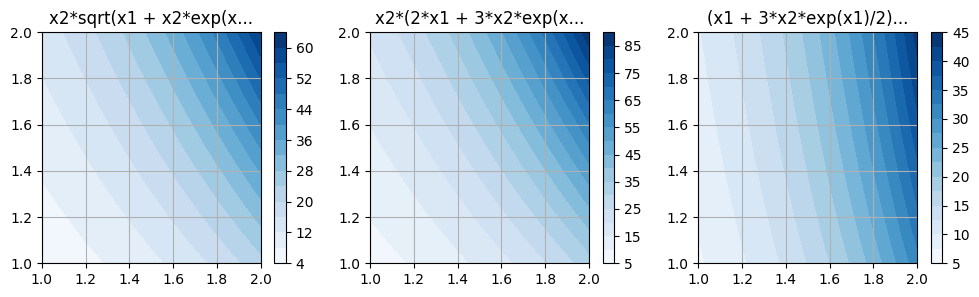

In [2]:
import numpy as np
import matplotlib.pyplot as plt
npf = lambda xy: f(xy[0], xy[1])
npdx = lambda xy: dx(xy[0], xy[1]); npdy = lambda xy: dy(xy[0], xy[1])
x1, x2 = np.meshgrid(np.linspace(1, 2, 50), np.linspace(1, 2, 50))
x1x2 = np.c_[np.ravel(x1), np.ravel(x2)]
fig, axes = plt.subplots(1, 3, figsize=(12, 3));
ax=axes[0]; ax.grid(); ax.set_title(f'{spf!s:.21s}...'); zz = np.apply_along_axis(npf, 1, x1x2)
cp = ax.contourf(x1, x2, zz.reshape(x1.shape), 16, cmap='Blues'); plt.colorbar(cp, ax=ax)
ax=axes[1]; ax.grid(); ax.set_title(f'{spdx!s:.21s}...'); zz = np.apply_along_axis(npdx, 1, x1x2)
cp = ax.contourf(x1, x2, zz.reshape(x1.shape), 16, cmap='Blues'); plt.colorbar(cp, ax=ax)
ax=axes[2]; ax.grid(); ax.set_title(f'{spdy!s:.21s}...'); zz = np.apply_along_axis(npdy, 1, x1x2)
cp = ax.contourf(x1, x2, zz.reshape(x1.shape), 16, cmap='Blues'); plt.colorbar(cp, ax=ax);

Claramente, la función ejemplo compone funciones diferenciables con un DAG distinto a una cadena simple
$$\begin{align*}
f(x_1,x_2)%
&=x_2\exp(x_1)\sqrt{x_1+x_2\exp(x_1)}\\%
&=x_2x_3\sqrt{x_1+x_2x_3}%
&&\text{con}&&x_3=f_3(x_1)=\exp(x_1)\\%
&=x_4\sqrt{x_1+x_4}%
&&\text{con}&&x_4=f_4(x_2,x_3)=x_2x_3\\%
&=x_4\sqrt{x_5}%
&&\text{con}&&x_5=f_5(x_1,x_4)=x_1+x_4\\%
&=x_4x_6%
&&\text{con}&&x_6=f_6(x_5)=\sqrt{x_5}\\%
&=x_7%
&&\text{con}&&x_7=f_7(x_4,x_6)=x_4x_6%
\end{align*}$$

In [3]:
import graphviz; graphviz.Source('''digraph { rankdir=LR {rank=same x1 x2}
x1 [shape="none"] x2 [shape="none"] x7 [shape="none", label="x7 = o"]
x1 -> f3 x1 -> f5 x2 -> f4 f3 -> f4 [label="x3"] f4 -> f5 [label="x4"] f4 -> f7 [label="x4"]
f5 -> f6 [label="x5"] f6 -> f7 [label="x6"] f7 -> x7
}''').render(filename='13.3.4 ejemplo', format='svg');

<div align="center">

<img src="13.3.4 ejemplo.svg" width="800"/>

</div>

Los nodos (funciones compuestas) se hallan numerados en orden topológico (padres antes que hijos). Para evitar cálculos repetidos, el paso backward de backprop procede en orden topológico inverso, sumando gradientes para caminos múltiples:
$$\begin{align*}
\frac{\partial o}{\partial x_7}&=\frac{\partial x_7}{\partial x_7}=1\\%
\frac{\partial o}{\partial x_6}&=\frac{\partial o}{\partial x_7}\frac{\partial x_7}{\partial x_6}=x_4\\%
\frac{\partial o}{\partial x_5}&=\frac{\partial o}{\partial x_6}\frac{\partial x_6}{\partial x_5}%
=\frac{x_4}{2\sqrt{x_5}}\\%
\frac{\partial o}{\partial x_4}&=\frac{\partial o}{\partial x_5}\frac{\partial x_5}{\partial x_4}%
+\frac{\partial o}{\partial x_7}\frac{\partial x_7}{\partial x_4}%
=\frac{x_4}{2\sqrt{x_5}}+x_6\\%
\frac{\partial o}{\partial x_3}&=\frac{\partial o}{\partial x_4}\frac{\partial x_4}{\partial x_3}%
=\frac{\partial o}{\partial x_4}x_2\\%
\frac{\partial o}{\partial x_2}&=\frac{\partial o}{\partial x_4}\frac{\partial x_4}{\partial x_2}%
=\frac{\partial o}{\partial x_4}x_3\\%
\frac{\partial o}{\partial x_1}&=\frac{\partial o}{\partial x_5}\frac{\partial x_5}{\partial x_1}%
+\frac{\partial o}{\partial x_3}\frac{\partial x_3}{\partial x_1}%
=\frac{\partial o}{\partial x_5}+\frac{\partial o}{\partial x_3}\exp(x_1)
\end{align*}$$

**Cálculo de Jacobianas en un DAG (con diferenciación hacia atrás):** $\;$ la Jacobiana de $\boldsymbol{o}$ en $\boldsymbol{x}_j$ es la suma, para todo hijo $k$ del nodo $j$, de su Jacobiana (ya calculada) o **adjunto**, multiplicado por la Jacobiana de $\boldsymbol{x}_k$ en $\boldsymbol{x}_j$
$$\frac{\partial\boldsymbol{o}}{\partial\boldsymbol{x}_j}=\sum_{k\in\operatorname{children(j)}}%
\frac{\partial\boldsymbol{o}}{\partial\boldsymbol{x}_k}\frac{\partial\boldsymbol{x}_k}{\partial\boldsymbol{x}_j}$$